# Importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(0)

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/dataset')

In [ ]:
pip install -U albumentations

In [ ]:
!pip uninstall opencv-python-headless
!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.1.2.30
Uninstalling opencv-python-headless-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.1.2.30.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtCore-bbdab771.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtGui-903938cd.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtTest-1183da5d.so.4.8.7
Proceed (y/n)? y
  Successfully uninstalled opencv-python-headless-4.1.2.30
  Using cached opencv_python_headless-4.1.2.30-cp37-cp37m-manylinux1_x86_64.whl (21.8 MB)


In [ ]:
import glob
import numpy as np
np.random.seed(0)
import random
random.seed(0)
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

In [ ]:
import torch
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset

# Create Train, Valid and Test sets

In [ ]:

####################################################
#       Create Train, Valid and Test sets
####################################################
train_data_path = '/content/drive/MyDrive/dataset/train' 
test_data_path = '/content/drive/MyDrive/dataset/test'
valid_data_path= '/content/drive/MyDrive/dataset/valid'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))

import itertools
train_image_paths = list(itertools.chain(*train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
#train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 
valid_image_paths = []
for data_path in glob.glob(valid_data_path + '/*'):
    valid_image_paths.append(glob.glob(data_path + '/*'))

valid_image_paths = list(itertools.chain(*valid_image_paths))
random.shuffle(valid_image_paths)
#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(itertools.chain(*test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  /content/drive/MyDrive/dataset/train/pneumonia/person62_bacteria_298.jpeg
class example:  covid
Train size: 8658
Valid size: 1500
Test size: 2160


In [ ]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
classes

['covid', 'normal', 'pneumonia']

In [ ]:
idx_to_class

{0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [ ]:
class_to_idx

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [ ]:
#######################################################
#               Define Transforms
#######################################################

#To define an augmentation pipeline, you need to create an instance of the Compose class.
#As an argument to the Compose class, you need to pass a list of augmentations you want to apply. 
#A call to Compose will return a transform function that will perform image augmentation.
#(https://albumentations.ai/docs/getting_started/image_augmentation/)

train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=512),
        #A.ShiftScaleRotate(shift_limit=0.00001, scale_limit=0.00001, rotate_limit=10, p=0.3),
        A.RandomCrop(height=512, width=512),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=512),
        A.CenterCrop(height=512, width=512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
#######################################################
#               Define Dataset Class
#######################################################

class XRayDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label
    
#######################################################
#                  Create Dataset
#######################################################

train_dataset = XRayDataset(train_image_paths, train_transforms)
valid_dataset = XRayDataset(valid_image_paths, test_transforms)
test_dataset = XRayDataset(test_image_paths, test_transforms)

In [ ]:
print('The shape of tensor for 50th image in train dataset: {}'.format(train_dataset[49][0].shape))
print('The label for 50th image in train dataset: {}'.format(train_dataset[49][1]))

The shape of tensor for 50th image in train dataset: torch.Size([3, 512, 512])
The label for 50th image in train dataset: 2


In [ ]:
len(train_dataset)

8658

In [ ]:
import matplotlib.pyplot as plt
import copy
%matplotlib inline

#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()  

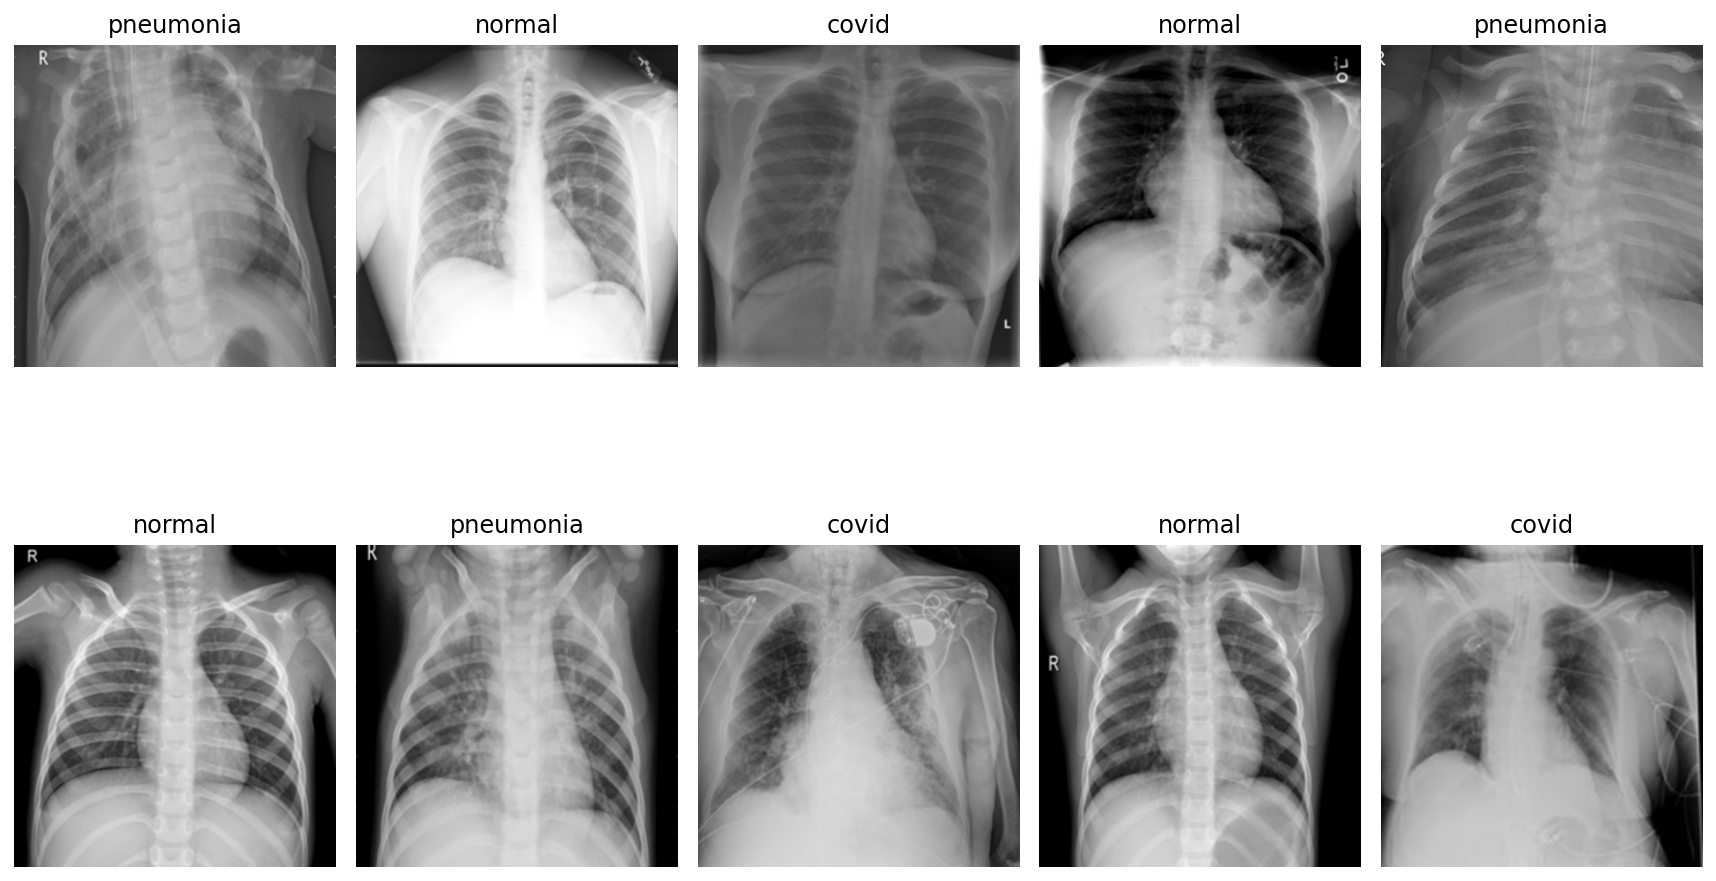

In [ ]:
visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

In [ ]:
#######################################################
#                  Define Dataloaders
#######################################################

#To avoid randomness
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, 
                          worker_init_fn=seed_worker, generator=g)

valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, 
                          worker_init_fn=seed_worker, generator=g)


test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, 
                         worker_init_fn=seed_worker, generator=g)

In [ ]:
batch = next(iter(train_loader))[0]
print('len:', len(batch))

len: 32


In [ ]:
#batch of image tensor
next(iter(train_loader))[0].shape

torch.Size([32, 3, 512, 512])

In [ ]:
#batch of the corresponding labels
next(iter(train_loader))[1].shape

torch.Size([32])

# Model Training

In [ ]:
import torchvision
####################################################
#                Define parameters
####################################################

params = {
#    "model": "densenet121",
    #"device": "cpu",
    "lr": 0.01,
    "batch_size": 32,
    "num_workers": 64,
    "n_epochs": 15,
    "image_size": 512, 
    "in_channels": 3, 
    "num_classes": 3
}

####################################################
#                Define Model
####################################################
def Net(num_classes):
    model = torchvision.models.densenet121(pretrained=True)
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    #model.classifier = torch.nn.Linear(in_features=1024, out_features=3)

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(1024, 512)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(512, 256)),
                              ('relu', nn.ReLU()),
                              ('fc3', nn.Linear(256, num_classes)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.classifier = classifier
    return model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = Net(params['num_classes'])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
model.to(device);

In [ ]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader):
    #put model in training state
    model.train()
    
    train_loss = 0.0
    
    #pbar = tqdm(enumerate(train_loader), total = len(train_loader))
    #for step, (imgs, labels) in pbar:
    
    for batch_idx, (imgs, labels) in enumerate(train_loader):  
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, labels)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
    
        train_loss+= ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        #if batch_idx%5==0:
        #    print('train loss', train_loss)
    
    print('Epoch {} avg Training loss: {:.3f}'.format(epoch+1, train_loss))
    
    return model, train_loss
        
def test_one_epoch(epoch, model, loss_fn, loader, img_paths):
    model.eval()
    
    #pbar = tqdm(enumerate(test_loader), total = len(test_loader))
    running_loss = 0
    actual_labels = []
    pred_labels = []
    
    #for step, (imgs, labels) in pbar:
    for batch_idx, (imgs, labels) in enumerate(loader):    
        imgs, labels = imgs.to(device), labels.to(device)
        log_preds = model(imgs)
        loss = loss_fn(log_preds, labels)
        
        
        preds = torch.exp(log_preds)
        running_loss+=((1 / (batch_idx + 1)) * (loss.data.item() - running_loss))
        
        #calculate accuracy
        top_prob, top_class = preds.topk(1, dim=1)
        pred_labels+= list((top_class.view(-1)).cpu().numpy())
        actual_labels+= list(labels.cpu().numpy())
        
        
    
    accuracy = ((np.array(pred_labels)==np.array(actual_labels)).sum())/len(img_paths) #size of test set
    correct = ((np.array(pred_labels)==np.array(actual_labels)).sum())
    total = len(img_paths)
    
    
    return running_loss, accuracy, correct, total, actual_labels, pred_labels


In [ ]:
#criterion = nn.BCEWithLogitsLoss()
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
#TRAINING 
train_losses = []
valid_losses = []
for epoch in range(params['n_epochs']):
    train_loss = train_one_epoch(epoch, model, loss_fn, optimizer, train_loader)
    train_losses+= [train_loss]
    
    
    valid_loss, accuracy, correct, total, actual_labels, pred_labels = test_one_epoch(epoch, model, loss_fn, valid_loader, valid_image_paths)
    valid_losses+=[valid_loss]
    print('Epoch {} avg Valid loss: {:.3f}'.format(epoch+1, valid_loss))
    print('Epoch {} Valid accuracy: {:.1%} ({} of {} right)\n'.format(epoch+1, accuracy, correct, total))
    
    if len(valid_losses)>1 and (valid_loss<min(valid_losses[:-1])):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            'train_transforms': train_transforms,
            'test_transforms': test_transforms,
            }, 'checkpoint.tar')

Epoch 1 avg Training loss: 1.161
Epoch 1 avg Valid loss: 1.864
Epoch 1 Valid accuracy: 56.1% (841 of 1500 right)

Epoch 2 avg Training loss: 0.440
Epoch 2 avg Valid loss: 2.922
Epoch 2 Valid accuracy: 47.7% (716 of 1500 right)

Epoch 3 avg Training loss: 0.362
Epoch 3 avg Valid loss: 2.008
Epoch 3 Valid accuracy: 55.5% (833 of 1500 right)

Epoch 4 avg Training loss: 0.376
Epoch 4 avg Valid loss: 1.328
Epoch 4 Valid accuracy: 61.4% (921 of 1500 right)

Epoch 5 avg Training loss: 0.383
Epoch 5 avg Valid loss: 3.405
Epoch 5 Valid accuracy: 49.4% (741 of 1500 right)

Epoch 6 avg Training loss: 0.357
Epoch 6 avg Valid loss: 2.707
Epoch 6 Valid accuracy: 56.5% (848 of 1500 right)

Epoch 7 avg Training loss: 0.358
Epoch 7 avg Valid loss: 1.807
Epoch 7 Valid accuracy: 57.8% (867 of 1500 right)

Epoch 8 avg Training loss: 0.330
Epoch 8 avg Valid loss: 2.063
Epoch 8 Valid accuracy: 52.3% (785 of 1500 right)

Epoch 9 avg Training loss: 0.318
Epoch 9 avg Valid loss: 2.021
Epoch 9 Valid accuracy: 5

In [ ]:
train_losses_all = [lis[1] for lis in train_losses]

In [ ]:
print(train_losses_all)

[1.160536568158228, 0.43979623207196983, 0.3623342318013584, 0.3760236254120006, 0.3830415602924639, 0.35740700996449976, 0.35758871340443743, 0.33037526828556485, 0.3178193366698012, 0.3571266984752622, 0.3217976541014397, 0.3044573180240018, 0.29733591382408925, 0.30094370676197707, 0.3025001146696589]


In [ ]:
print(valid_losses)

[1.8637015527867251, 2.9216472848932784, 2.0078327884065343, 1.3281042664609053, 3.4050548152720674, 2.70746506021378, 1.8071064746126215, 2.063400286309262, 2.0211175527978447, 2.417772757246139, 3.667462201828652, 2.143237096198062, 1.6401396051366277, 3.6369785070419316, 2.183760399514056]


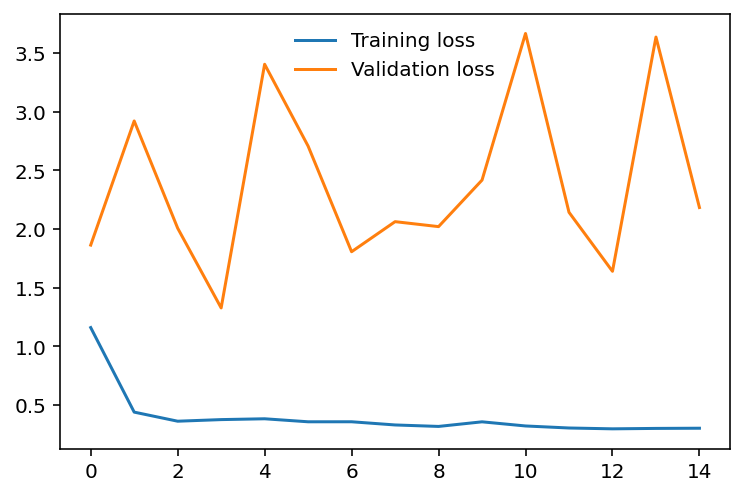

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses_all, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

# Model Evaluation

In [ ]:
# load the model that got the best validation accuracy
checkpoint = torch.load('/content/drive/MyDrive/dataset/checkpoint.tar')
loaded_model = Net(params['num_classes'])
loaded_model.to(device)
loaded_model.load_state_dict(checkpoint['model_state_dict'])

loaded_criterion = checkpoint['loss']

#While Training Again uncomment 
#optimizer = optim.Adam(model.parameters(), lr = 0.01)
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

last_epoch = checkpoint['epoch']+1

test_loss, accuracy, correct, total, actual_labels, pred_labels = test_one_epoch(None, loaded_model, loaded_criterion, test_loader, test_image_paths)

print('Test loss: {:.3f}'.format(test_loss))
print('Test accuracy: {:.1%} ({} of {} right)\n'.format(accuracy, correct, total))


FileNotFoundError: ignored

In [ ]:
torch.save(loaded_model, 'CheXNet_Model.pth')

In [ ]:
print(actual_labels)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [ ]:
print(pred_labels)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 

In [ ]:
import sklearn
from sklearn.metrics import classification_report
target_names = classes
print(classification_report(actual_labels, pred_labels, target_names = classes))

              precision    recall  f1-score   support

       covid       0.77      0.88      0.82       720
      normal       0.86      0.74      0.80       720
   pneumonia       1.00      1.00      1.00       720

    accuracy                           0.87      2160
   macro avg       0.88      0.87      0.87      2160
weighted avg       0.88      0.87      0.87      2160



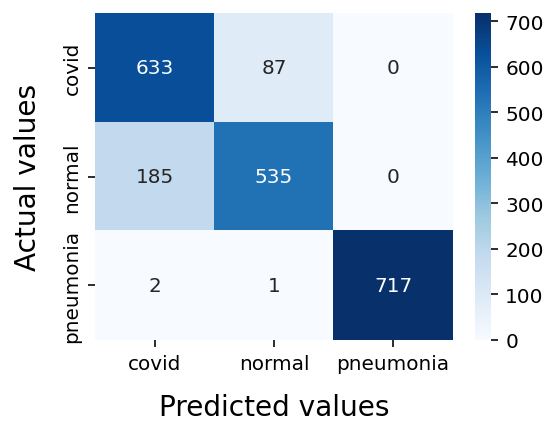

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix_test = confusion_matrix(actual_labels, pred_labels)

f,ax = plt.subplots(figsize=(4,3))

sns.heatmap(confusion_matrix_test, annot=True, cmap='Blues',fmt='d',
            xticklabels = target_names,
            yticklabels = target_names)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.show()

# Unknown X-Ray Image Prediction from Trained Model

## Importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(0)

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/dataset')

In [ ]:
#Only execute if not executed before
!pip install -U albumentations

     |████████████████████████████████| 102 kB 6.6 MB/s 
     |████████████████████████████████| 47.8 MB 3.7 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import random
random.seed(0)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

## Load Trained Model

In [ ]:
import torch
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler

In [ ]:
!pip uninstall opencv-python-headless
!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [ ]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
np.random.seed(0)
test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=512),
        A.CenterCrop(height=512, width=512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
#######################################################
#      Create dictionary for class indexes
#######################################################
classes = ['normal', 'covid', 'pneumonia']
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
idx_to_class

{0: 'normal', 1: 'covid', 2: 'pneumonia'}

In [ ]:
import torchvision
####################################################
#                Define parameters
####################################################

params = {
#    "model": "densenet121",
    #"device": "cpu",
    "lr": 0.01,
    "batch_size": 32,
    "num_workers": 64,
    "n_epochs": 15,
    "image_size": 512, 
    "in_channels": 3, 
    "num_classes": 3
}

####################################################
#                Define Model
####################################################
def Net(num_classes):
    model = torchvision.models.densenet121(pretrained=True)
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    #model.classifier = torch.nn.Linear(in_features=1024, out_features=3)

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(1024, 512)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(512, 256)),
                              ('relu', nn.ReLU()),
                              ('fc3', nn.Linear(256, num_classes)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.classifier = classifier
    return model

In [ ]:
#Load Trained Model from checkpoint.tar
import torch
if(torch.cuda.is_available() == False):
    checkpoint = torch.load('/content/drive/MyDrive/dataset/checkpoint.tar', map_location ='cpu')
else:
    checkpoint = torch.load('/content/drive/MyDrive/dataset/checkpoint.tar')
loaded_model = Net(params['num_classes'])

loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_criterion = checkpoint['loss']

#While Training Again uncomment 
#optimizer = optim.Adam(model.parameters(), lr = 0.01)
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

FileNotFoundError: ignored

## Upload Image

In [ ]:
from google.colab import files
from io import BytesIO
from PIL import Image

uploaded = files.upload()
for fn in uploaded.keys():
    ImageName = fn
    ImageBytes =len(uploaded[fn])

Saving COVID-2893.png to COVID-2893.png


## Predict For Uploaded Image

In [ ]:
image = cv2.imread(ImageName) #Reading Image from path(/Image_Name.jpg) eg. here - /content/pneumonia bacterial.jpg
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_tensor = test_transforms(image=image)["image"]
input_tensor = image_tensor.unsqueeze(0) 
input_tensor = input_tensor.to(device)

loaded_model.eval()
prediction = np.argmax(loaded_model(input_tensor).detach().cpu().numpy())
Predicted_Class = idx_to_class[prediction]


In [ ]:
print(Predicted_Class)

normal


## Probability of Prediction for All 3 Classes

In [ ]:
import numpy as np
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [ ]:
loaded_model(input_tensor).detach().cpu().numpy()

array([[-9.2880492e-04, -6.9876976e+00, -1.2154467e+01]], dtype=float32)

In [ ]:
model_output = loaded_model(input_tensor).detach().cpu().numpy().flatten()

In [ ]:
probabilities = softmax(model_output)
print(probabilities)

[9.9907160e-01 9.2316966e-04 5.2648047e-06]


# GPU Testing

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize



  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=3c1d93d48c6bb1bbcdecb646cad4e85bf8e3df3e223234475ba5b046f84f72e6
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [ ]:
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.2 GB  |     Proc size: 3.8 GB
GPU RAM Free: 7733MB | Used: 3708MB | Util  32% | Total     11441MB


In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
torch.save(loaded_model,'something.h5')